### Inference with trained RT-DETR model ###

In [1]:
import os
import ast
import re
import numpy as np
import pandas as pd
import logging
import glob
from pathlib import Path

from matplotlib import pyplot as plt
from matplotlib import patches

# PyTorch and HuggingFace Transformers
import torch
from transformers import RTDetrV2ForObjectDetection, RTDetrImageProcessor

logger = logging.getLogger(name=__name__)

# Appearance of the Notebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
np.set_printoptions(linewidth=110)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# Import this module with autoreload
%load_ext autoreload
%autoreload 2
import detection as dt
from detection.dentexdata import DentexData
from detection.detrdataset import get_gpu_info, DetectionDatasetFromDF
from detection.fileutils import FileOP
from detection.imageproc import ImageData, xyxy2xywh, xywh2xyxy, clipxywh

print(f'Project module version: {dt.__version__}')
print(f'PyTorch version:        {torch.__version__}')

Project module version: 0.0.1.post1.dev31+g14d1a25.d20250315
PyTorch version:        2.6.0a0+ecf3bae40a.nv25.01


In [2]:
# Check GPU availability
device, device_str = get_gpu_info()

CUDA available: True
Number of GPUs found:  1
Current device ID: 0
GPU device name:   NVIDIA GeForce RTX 3060 Laptop GPU
PyTorch version:   2.6.0a0+ecf3bae40a.nv25.01
CUDA version:      12.8
CUDNN version:     90700


In [3]:
# Create a function to show an image with bounding boxes
def show_image_with_boxes(image, box_list, label_list=None, alpha=0.7, edgecolor=None, ax=None):
    color = plt.cm.rainbow(np.linspace(0, 1, len(box_list)))
    color_list = [color[c] for c in range(len(color))]
    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(image)
    for b, box in enumerate(box_list):
        if edgecolor is None:
            boxcolor = color_list[b]
        else:
            boxcolor = edgecolor
        anchor = (box[0], box[1])
        width = box[2]
        height = box[3]
        #anchor, width, height = rectangle(box)
        rect = patches.Rectangle(xy=anchor, 
                                 width=width, 
                                 height=height, 
                                 linewidth=2.5, 
                                 edgecolor=boxcolor, 
                                 facecolor='none', 
                                 alpha=alpha)
        ax.add_patch(rect)
        if label_list is not None:
            ax.text(x=anchor[0]+width/2, y=anchor[1]-3, s=label_list[b], color=boxcolor)
    ax.set(xticks=[], yticks=[])
    return ax

In [4]:
# Directories and files
data_dir = os.path.join(os.environ.get('HOME'), 'data', 'dentex_detection')
image_dir = os.path.join(data_dir, 'quadrants')

# Model directory
model_name = 'rtdetr_250311_06'
model_dir = os.path.join(data_dir, 'models', model_name)

# Log file
log_file_name = 'train_log_250311.log'
log_file = os.path.join(model_dir, log_file_name)

# Output for the images with the predictions
output_dir = os.path.join(model_dir, 'testresults')
Path(output_dir).mkdir(parents=True, exist_ok=True)

dataset_df_file_name = 'train_split_250224.parquet'
dataset_df_file = os.path.join(image_dir, dataset_df_file_name)
df = pd.read_parquet(dataset_df_file)
display(df.head(2))

# Show the number of images and annotations for each data set
print(f'Total number of quadrant images: {len(df['file_name'].unique())}')
print(f'Total nunmber of annotations:    {df.shape[0]}')
      
dset_list = ['train', 'val', 'test']
for dset in dset_list:
    print()
    print(f'Image and annotations for dataset {dset.upper()}')
    n_images = len(df.loc[df['dset'] == dset, 'file_name'].unique())
    n_annotations = df.loc[df['dset'] == dset].shape[0]
    print(f'    IMAGES:      {n_images}')
    print(f'    ANNOTATIONS: {n_annotations}')

,file_name,quadrant,pos,bbox,segmentation,fdi,ada,dset
0,train_0_1.png,1,1,"[666, 102, 103, 376]","[[757, 478, 769, 102, 678, 113, 666, 469]]",11,8,train
1,train_0_1.png,1,2,"[593, 107, 85, 377]","[[666, 484, 678, 110, 607, 107, 604, 299, 619,...",12,7,train


Total number of quadrant images: 2531
Total nunmber of annotations:    18095

Image and annotations for dataset TRAIN
    IMAGES:      2479
    ANNOTATIONS: 17711

Image and annotations for dataset VAL
    IMAGES:      20
    ANNOTATIONS: 149

Image and annotations for dataset TEST
    IMAGES:      32
    ANNOTATIONS: 235


In [5]:
# convert class id to ada position
ada_list = sorted(list(df['ada'].unique()))
id2label = dict(zip(range(len(ada_list)), ada_list))
label2id = {v: k for k, v in id2label.items()}

In [6]:
# Load the log file
with open(log_file, mode='r') as fl:
    log = fl.read()
print(log)

250311-21:25-__main__-INFO-{"output_dir": "/app/data/dentex_detection/model/rtdetr_250311_06", "num_train_epochs": 500, "max_grad_norm": 0.1, "learning_rate": 1e-05, "warmup_steps": 300, "per_device_train_batch_size": 48, "dataloader_num_workers": 8, "metric_for_best_model": "eval_map", "greater_is_better": true, "load_best_model_at_end": true, "eval_strategy": "epoch", "save_strategy": "epoch", "save_total_limit": 5, "remove_unused_columns": false, "eval_do_concat_batches": false}
250311-21:25-__main__-INFO-{"model_version": 6, "model_name": "rtdetr_250311_06", "hf_checkpoint": "PekingU/rtdetr_v2_r101vd", "use_transform": "transform_1"}



In [7]:
# Load the model from checkpoint
hf_model_name = 'PekingU/rtdetr_v2_r101vd'
processor = RTDetrImageProcessor.from_pretrained(hf_model_name)
checkpoint_name = 'checkpoint-10140'
checkpoint_file = os.path.join(model_dir, checkpoint_name)
model = RTDetrV2ForObjectDetection.from_pretrained(checkpoint_file).to(device)

In [8]:
test_image_list = df.loc[df['dset'] == 'test', 'file_name'].unique()
print(len(test_image_list))

32


In [9]:
# Get the image and ground-truth data
file_idx = 10
file_name = test_image_list[file_idx]
file_base_name = os.path.splitext(file_name)[0]
print(file_base_name)

df_file = df.loc[df['file_name'] == file_name]
file_box_list = df_file['bbox'].tolist()
file_label_list = df_file['ada'].tolist()
quadrant = df_file['quadrant'].unique()[0]
print(quadrant)
display(df_file)

# Load the image
file = os.path.join(image_dir, file_name)
im = ImageData().load_image(file)
im_input = processor(im, return_tensors='pt').to(device)
xlim, ylim = (0, im.shape[1]), (0, im.shape[0])

train_344_2
2


,file_name,quadrant,pos,bbox,segmentation,fdi,ada,dset
17934,train_344_2.png,2,1,"[10, 25, 82, 421]","[[18, 346, 10, 416, 19, 436, 47, 446, 89, 427,...",21,9,test
17935,train_344_2.png,2,2,"[82, 114, 70, 307]","[[86, 318, 82, 364, 117, 416, 152, 421, 152, 3...",22,10,test
17936,train_344_2.png,2,3,"[151, 11, 90, 432]","[[151, 320, 155, 400, 170, 427, 206, 443, 233,...",23,11,test
17937,train_344_2.png,2,4,"[207, 10, 111, 434]","[[208, 334, 207, 406, 235, 437, 254, 433, 286,...",24,12,test
17938,train_344_2.png,2,5,"[293, 73, 109, 368]","[[293, 341, 293, 416, 341, 441, 377, 438, 399,...",25,13,test
17939,train_344_2.png,2,6,"[383, 78, 129, 339]","[[391, 344, 383, 370, 403, 399, 438, 417, 499,...",26,14,test
17940,train_344_2.png,2,7,"[494, 105, 131, 322]","[[494, 336, 494, 386, 512, 422, 536, 427, 578,...",27,15,test
17941,train_344_2.png,2,8,"[559, 15, 129, 291]","[[573, 246, 586, 289, 620, 306, 657, 280, 677,...",28,16,test


In [10]:
# Run the image through the model
with torch.no_grad():
    model_output = model(**im_input)
# Post-processing: Non-Maximum Suppression (NMS)
threshold = 0.3
results = processor.post_process_object_detection(model_output, 
                                                  target_sizes=torch.tensor([(im.shape[0], im.shape[1])]), 
                                                  threshold=threshold)
print(f'Number of bounding boxes for model output: {len(model_output.get("pred_boxes")[0])}')
print(list(results[0].keys()))
print(f'Number of bounding boxes after post-processing: {len(results[0].get("boxes"))}')
print()
display(results)

Number of bounding boxes for model output: 300
['scores', 'labels', 'boxes']
Number of bounding boxes after post-processing: 6



[{'scores': tensor([0.5452, 0.5301, 0.5295, 0.4094, 0.3737, 0.3640], device='cuda:0'),
  'labels': tensor([14,  8, 10, 15,  9, 13], device='cuda:0'),
  'boxes': tensor([[490.9384, 124.9723, 628.6260, 429.7969],
          [  9.6265,  41.7963,  95.0201, 442.2213],
          [145.9971,  15.8323, 246.7442, 443.2292],
          [544.4047,  63.1400, 686.8417, 306.3192],
          [ 83.7676,  48.1815, 160.3804, 430.6006],
          [379.1580, 123.9626, 505.5208, 422.3759]], device='cuda:0')}]

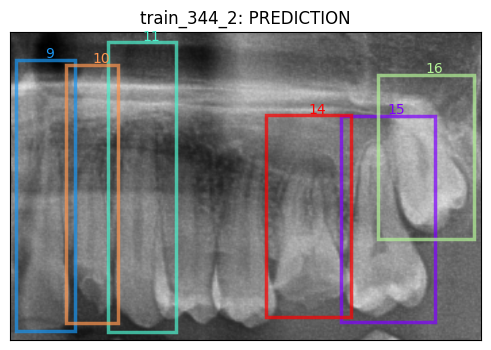

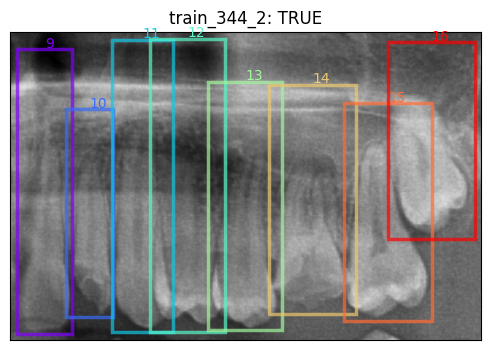

In [12]:
output = results[0]

scores = output.get('scores').cpu().numpy()
labels = output.get('labels').cpu().numpy()
label_list = [id2label.get(i) for i in labels]
boxes = list(output.get('boxes').cpu().numpy())
box_list = [clipxywh(xyxy2xywh(list(box)), xlim=xlim, ylim=ylim, decimals=0) for box in boxes]
figsize = (8, 4)

# Show the prediction
fig, ax = plt.subplots(figsize=figsize)
ax = show_image_with_boxes(image=im, 
                           box_list=box_list, 
                           label_list=label_list, alpha=0.7, ax=ax)
ax.set_title(f'{file_base_name}: PREDICTION')
overlay_file_name = f'{file_base_name}_{model_name}_pred.png'
overlay_file = os.path.join(output_dir, overlay_file_name)
plt.savefig(overlay_file, bbox_inches='tight')
plt.show()

# Show the ground truth
fig, ax = plt.subplots(figsize=figsize)
ax = show_image_with_boxes(image=im, 
                           box_list=file_box_list, 
                           label_list=file_label_list, alpha=0.7, ax=ax)
ax.set_title(f'{file_base_name}: TRUE')
overlay_file_name = f'{file_base_name}_{model_name}_true.png'
overlay_file = os.path.join(output_dir, overlay_file_name)
plt.savefig(overlay_file, bbox_inches='tight')
plt.show()